In [1]:
import numpy as np 
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
img_size = 224
batch_size = 8 


train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True
        )

train_generator = train_datagen.flow_from_directory(
        '../input/plates3/',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        classes=['cleaned', 'dirty'],
        class_mode='binary',
subset='training')



Found 40 images belonging to 2 classes.


In [3]:
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(  
        '../input/plates2/test/',
        classes=['test'],
        target_size = (img_size, img_size),
        batch_size = 1,
        shuffle = False,        
        class_mode = 'binary')

Found 744 images belonging to 1 classes.


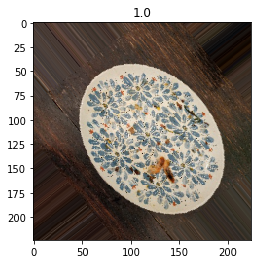

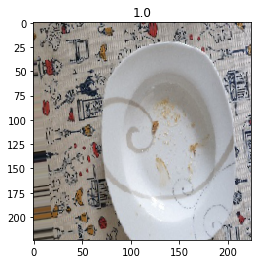

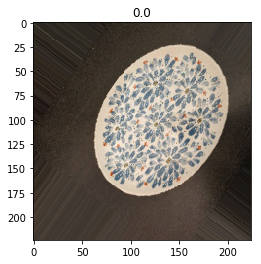

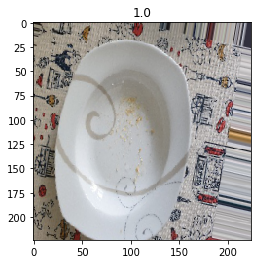

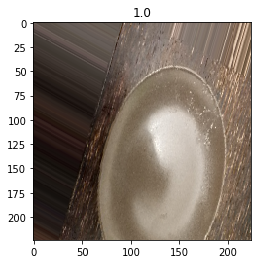

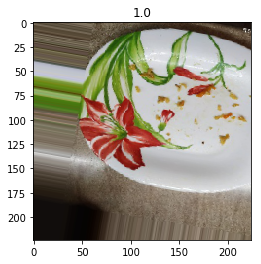

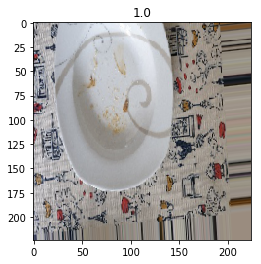

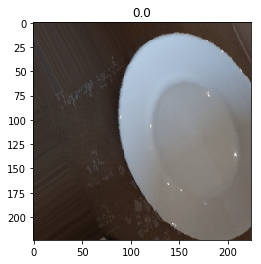

In [4]:
#посмотрим на обучающую выборку
i=0
for batch in train_generator:
    title = batch[1][i]
    batch = batch[0][i].reshape(224, 224, 3)
    a = array_to_img(batch)
                          
    plt.imshow(a)
    plt.title(title)
    plt.show()
    i += 1
    if i > 7:
        break

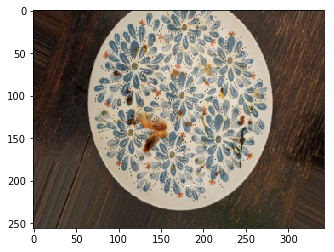

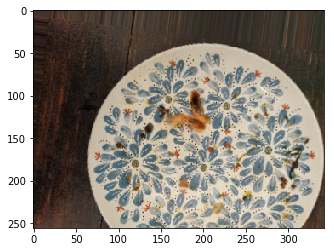

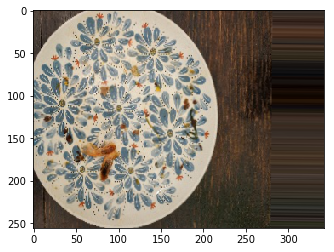

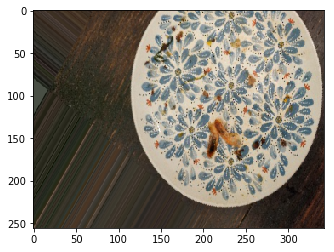

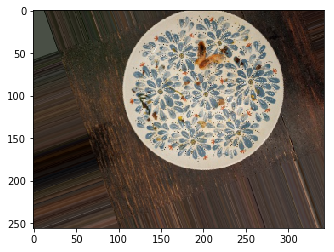

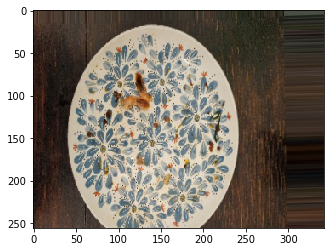

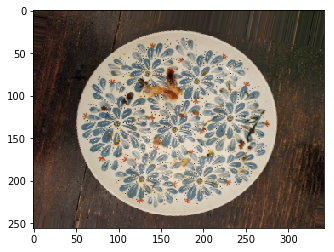

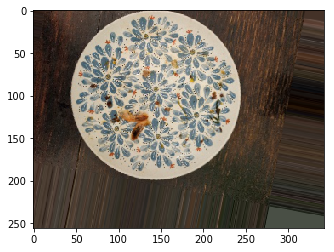

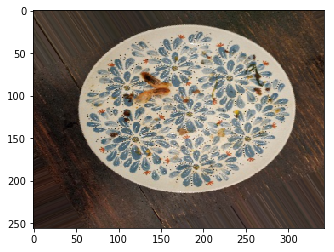

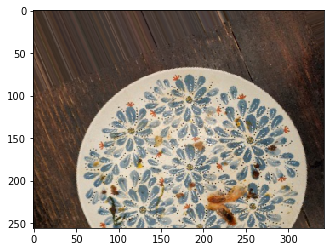

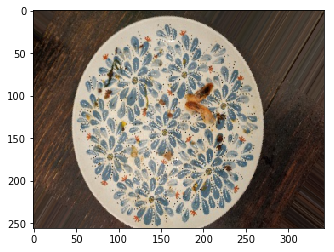

In [5]:
#так как данных мало необходимо применение аугментации, посмотрим на наши новые изображения

img = load_img('../input/plates3/dirty/dirty/0000.jpg') 
x = img_to_array(img)  
sh = x.shape
x = x.reshape((1,) + x.shape) 
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    batch = batch.reshape(sh)
    a = array_to_img(batch)
    plt.imshow(a)
    plt.show()
    i += 1
    if i > 10:
        break  

In [ ]:
#в связи с малым датасетом будем использовать предобученную модель
from keras.applications import InceptionResNetV2  

conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

#conv_base.summary()

 90054656/219055592 [===========>..................] - ETA: 6s

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#conv_base.trainable = False

conv_base.trainable = True #переобучим последние слои модели

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv_7b':  
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),  
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=300,
      epochs=10,
      verbose=2)

model.save_weights('keras_plates.h5') 

 - 78s - loss: 129.2069 - acc: 0.8117
Epoch 2/10
 - 52s - loss: 44.3767 - acc: 0.9163
Epoch 3/10
 - 53s - loss: 14.8247 - acc: 0.9254
Epoch 4/10
 - 53s - loss: 5.8777 - acc: 0.9367
Epoch 5/10
 - 54s - loss: 2.5939 - acc: 0.9413
Epoch 6/10
 - 54s - loss: 1.2808 - acc: 0.9400
Epoch 7/10
 - 54s - loss: 0.7012 - acc: 0.9513
Epoch 8/10
 - 54s - loss: 0.4244 - acc: 0.9533
Epoch 9/10
 - 54s - loss: 0.3344 - acc: 0.9454
Epoch 10/10
 - 54s - loss: 0.2091 - acc: 0.9637


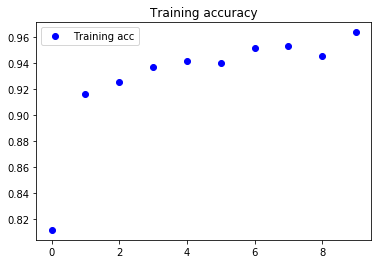

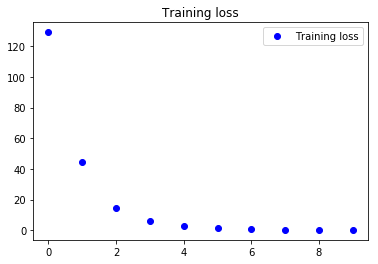

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [11]:
test_generator.reset()
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))
d = {'id': [n for n in range(len(predict))], 
     'label': ['dirty' if x > 0.9 else 'cleaned' for x in predict]}
result_df = pd.DataFrame(data=d)
print(result_df['label'].value_counts())
result_df.to_csv('Plates_kaggle_sub.csv', index=False)

dirty      505
cleaned    239
Name: label, dtype: int64


In [14]:
result_df.head(15)

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty
5,5,dirty
6,6,dirty
7,7,dirty
8,8,dirty
9,9,dirty
